In [1]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from img2vec import grayscale2emb
import math
import os
import pandas as pd
import joblib

In [2]:
# Define the batch size
batch_size = 64

### Read the data

In [3]:
train_data = pd.read_csv(os.path.join('..', '..', 'data', 'train.csv'))
val_data = pd.read_csv(os.path.join('..', '..', 'data', 'val.csv'))
test_data = pd.read_csv(os.path.join('..', '..', 'data', 'test.csv'))

### Encode age labels

In [4]:
age_encoder = LabelEncoder()
train_data['age_label'] = age_encoder.fit_transform(train_data['age'])
val_data['age_label'] = age_encoder.transform(val_data['age'])
test_data['age_label'] = age_encoder.transform(test_data['age'])
num_classes = len(age_encoder.classes_)
print("Age classes:", age_encoder.classes_)

Age classes: ['(0, 2)' '(15, 20)' '(25, 32)' '(38, 43)' '(4, 6)' '(48, 53)' '(60, 100)'
 '(8, 23)']


### Save the encoder

In [5]:
joblib.dump(age_encoder, 'age_encoder.pkl')
print("Age encoder saved successfully.")

Age encoder saved successfully.


### Add image paths

In [6]:
def construct_img_path(row):
    return os.path.join("..", "..", "data", "faces", row['user_id'],
                        "coarse_tilt_aligned_face." + str(row['face_id']) + "." + row['original_image'])

train_data['img_path'] = train_data.apply(construct_img_path, axis=1)
val_data['img_path'] = val_data.apply(construct_img_path, axis=1)
test_data['img_path'] = test_data.apply(construct_img_path, axis=1)


### Check if images exist

In [7]:
train_data['img_exists'] = train_data['img_path'].apply(os.path.exists)
val_data['img_exists'] = val_data['img_path'].apply(os.path.exists)
test_data['img_exists'] = test_data['img_path'].apply(os.path.exists)

### Filter out any rows where the image doesn't exist

In [8]:
train_data_filtered = train_data[train_data['img_exists'] == True]
val_data_filtered = val_data[val_data['img_exists'] == True]
test_data_filtered = test_data[test_data['img_exists'] == True]

### Extract image paths and labels

In [9]:
train_image_paths = train_data_filtered['img_path'].tolist()
train_labels = train_data_filtered['age_label'].values

val_image_paths = val_data_filtered['img_path'].tolist()
val_labels = val_data_filtered['age_label'].values

test_image_paths = test_data_filtered['img_path'].tolist()
test_labels = test_data_filtered['age_label'].values

### Define function that process features in batches and store them to avoid recomputation

In [10]:
def preprocess_and_save_features(image_paths, output_file, batch_size=64):
    if os.path.exists(output_file):
        print(f"Loading pre-processed features from {output_file}")
        return np.load(output_file)
    
    print(f"Processing {len(image_paths)} images and saving to {output_file}")
    all_features = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}/{math.ceil(len(image_paths)/batch_size)}")
        batch_features = grayscale2emb(batch_paths)
        all_features.append(batch_features)
    
    all_features = np.vstack(all_features)
    np.save(output_file, all_features)
    return all_features

### Process and save features

In [11]:
train_features = preprocess_and_save_features(train_image_paths, 'train_features.npy')
val_features = preprocess_and_save_features(val_image_paths, 'val_features.npy')
test_features = preprocess_and_save_features(test_image_paths, 'test_features.npy')

Processing 11856 images and saving to train_features.npy
Processing batch 1/186
Processing batch 2/186
Processing batch 3/186
Processing batch 4/186
Processing batch 5/186
Processing batch 6/186
Processing batch 7/186
Processing batch 8/186
Processing batch 9/186
Processing batch 10/186
Processing batch 11/186
Processing batch 12/186
Processing batch 13/186
Processing batch 14/186
Processing batch 15/186
Processing batch 16/186
Processing batch 17/186
Processing batch 18/186
Processing batch 19/186
Processing batch 20/186
Processing batch 21/186
Processing batch 22/186
Processing batch 23/186
Processing batch 24/186
Processing batch 25/186
Processing batch 26/186
Processing batch 27/186
Processing batch 28/186
Processing batch 29/186
Processing batch 30/186
Processing batch 31/186
Processing batch 32/186
Processing batch 33/186
Processing batch 34/186
Processing batch 35/186
Processing batch 36/186
Processing batch 37/186
Processing batch 38/186
Processing batch 39/186
Processing batch

### Standardize features

In [12]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
val_features_scaled = scaler.transform(val_features)
test_features_scaled = scaler.transform(test_features)

### Save the scaler

In [13]:
joblib.dump(scaler, 'feature_scaler.pkl')

['feature_scaler.pkl']

### Define a simple softmax model 

In [14]:
model = Sequential([
    Dense(num_classes, activation='softmax', input_shape=(train_features.shape[1],))
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,392 (64.03 KB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [15]:
print("Training the model...")
history = model.fit(
    train_features_scaled, train_labels,
    validation_data=(val_features_scaled, val_labels),
    epochs=30,
    batch_size=batch_size,
)

Training the model...
Epoch 1/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3820 - loss: 1.7796 - val_accuracy: 0.5327 - val_loss: 1.2520
Epoch 2/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5855 - loss: 1.1140 - val_accuracy: 0.5742 - val_loss: 1.1544
Epoch 3/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6552 - loss: 0.9334 - val_accuracy: 0.5992 - val_loss: 1.1078
Epoch 4/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6881 - loss: 0.8460 - val_accuracy: 0.6110 - val_loss: 1.0861
Epoch 5/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7173 - loss: 0.7837 - val_accuracy: 0.6134 - val_loss: 1.0845
Epoch 6/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7424 - loss: 0.7360 - val_accuracy: 0.6194 - val_loss: 1.0744
Epoch 7/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7469 - loss: 0.6970 - val_accuracy: 0.6194 - val_loss: 1.0729
Epoch 8/30
186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7713 - loss: 0.

### Save the model

In [16]:
model.save('softmax_age_classifier.h5')
print("Model saved successfully.")

Model saved successfully.


### Evaluate the model

In [17]:
print("Evaluating the model on test data...")
test_loss, test_acc = model.evaluate(test_features_scaled, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Evaluating the model on test data...
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4353 - loss: 2.2079
Test Loss: 2.3760
Test Accuracy: 0.4063


### Get predictions

In [18]:
test_predictions = model.predict(test_features_scaled)
test_pred_classes = np.argmax(test_predictions, axis=1)

117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### Visualize results

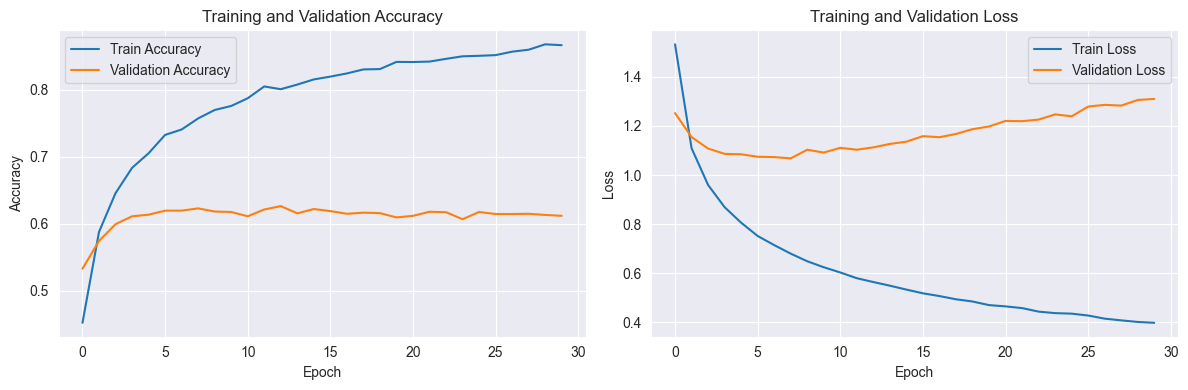

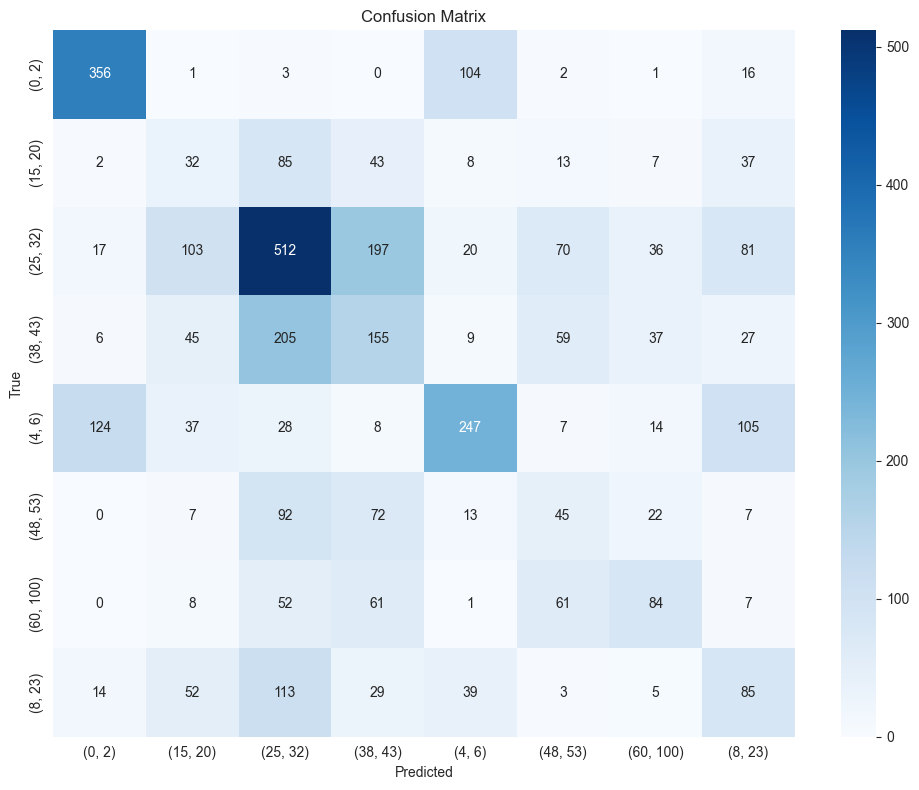

In [19]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, test_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=age_encoder.classes_,
            yticklabels=age_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

### Classification report

In [20]:
print("Classification Report:")
print(classification_report(test_labels, test_pred_classes, target_names=age_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

      (0, 2)       0.69      0.74      0.71       483
    (15, 20)       0.11      0.14      0.12       227
    (25, 32)       0.47      0.49      0.48      1036
    (38, 43)       0.27      0.29      0.28       543
      (4, 6)       0.56      0.43      0.49       570
    (48, 53)       0.17      0.17      0.17       258
   (60, 100)       0.41      0.31      0.35       274
     (8, 23)       0.23      0.25      0.24       340

    accuracy                           0.41      3731
   macro avg       0.36      0.35      0.36      3731
weighted avg       0.41      0.41      0.41      3731


### Example of using the model

Model loaded successfully.
Age encoder loaded successfully.
Feature scaler loaded successfully.
Using sample image: ..\..\data\faces\115321157@N03\coarse_tilt_aligned_face.1744.12111738395_a7f715aa4e_o.jpg
Extracting features from ..\..\data\faces\115321157@N03\coarse_tilt_aligned_face.1744.12111738395_a7f715aa4e_o.jpg...
Standardizing features...
Making prediction...
Predicted age range: (4, 6) with confidence 0.63


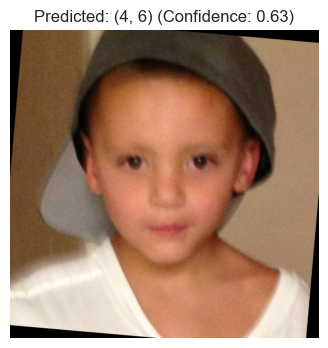


Code for making predictions on new images:


In [21]:
# Load the trained model
model = tf.keras.models.load_model('softmax_age_classifier.h5')
print("Model loaded successfully.")

# Load the LabelEncoder
age_encoder = joblib.load('age_encoder.pkl')
print("Age encoder loaded successfully.")

# Load the scaler
scaler = joblib.load('feature_scaler.pkl')
print("Feature scaler loaded successfully.")

def predict_age(image_path, model, age_encoder, scaler):
    """
    Predict the age range for a given face image.
    
    Parameters:
    image_path (str): Path to the image file
    model: Trained Keras model
    age_encoder: Trained LabelEncoder for age classes
    scaler: Trained StandardScaler for feature normalization
    
    Returns:
    tuple: (predicted_age_range, confidence)
    """
    # Check if file exists
    if not os.path.exists(image_path):
        print(f"Error: File {image_path} not found")
        return None, 0
        
    # Extract features
    print(f"Extracting features from {image_path}...")
    features = grayscale2emb([image_path])
    
    # Check if feature extraction was successful
    if features.size == 0:
        print("Error: Feature extraction failed")
        return None, 0
        
    # Standardize features
    print("Standardizing features...")
    features_scaled = scaler.transform(features)
    
    # Make prediction
    print("Making prediction...")
    pred_probs = model.predict(features_scaled, verbose=0)[0]
    
    # Get predicted class
    pred_class = np.argmax(pred_probs)
    
    # Convert to age range
    pred_age_range = age_encoder.classes_[pred_class]
    confidence = pred_probs[pred_class]

    return pred_age_range, confidence

# Example usage with a sample image
# Replace with an actual path to test
sample_image_path = test_image_paths[0]  # Using the first test image as an example
print(f"Using sample image: {sample_image_path}")

# Make prediction
pred_age, confidence = predict_age(sample_image_path, model, age_encoder, scaler)

if pred_age is not None:
    print(f"Predicted age range: {pred_age} with confidence {confidence:.2f}")
    
    # Display the image if possible
    try:
        from PIL import Image
        img = Image.open(sample_image_path)
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"Predicted: {pred_age} (Confidence: {confidence:.2f})")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Could not display image: {e}")

print("\nCode for making predictions on new images:")